# Exercise session 2: Fitting problems

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import linprog

### Exercise 1: Linear least squares $\ell_2$ fitting

Fit a line $b = x_1 a + x_2$ to measurements $(a_i, b_i) \in \mathbb{R}^2, i \in \{1, \dots, N\}$ by minimising the residuals

$$
\min_{x \in \mathbb{R}^2}{ \sum_{i=1}^N{ ( x_1 a + x_2 - b_i )^2 } }
= \Bigg\Vert
\begin{pmatrix} a_1 & 1 \\ \vdots & \vdots \\ a_N & 1 \end{pmatrix}
\begin{pmatrix} x_1 & x_2 \end{pmatrix}
-
\begin{pmatrix} b_1 \\ \vdots \\ b_N \end{pmatrix}
\Bigg\Vert_2^2
= \Vert Ax - b \Vert_2^2
$$

**Task 1a**: Generate a vector of "measurements".

In [2]:
N = 50
a = np.linspace(0, 1, N)

print(a.shape)

(50,)


In [3]:
a = a.reshape(-1, 1)  # by convention we work with COLUMN vectors
b = 4 * a - 1

print(a.shape)

(50, 1)


**Task 1b**: Add Gaussian-noise with variance 1 to the *b* values and plot the obtained measurements

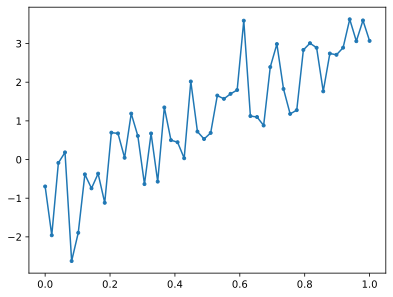

In [4]:
rng = np.random.default_rng(seed=42)
b += rng.standard_normal((N, 1))  # COLUMN vector of size (N,1)

plt.plot(a, b, '.-')
plt.show()

**Task 1c**: Find the coefficients $x_1$ and $x_2$ of the $\ell_2$ fitting problem.
Plot the obtained line into the same graph as the measurements.

- To solve an invertible linear system $z = M^{-1}v$ with $M \in \mathrm{I\!R}^{m \times m}$, you can use `np.linalg.solve`. This can be used to solve the normal equations $A^\top A x = A^\top b$.
- Because the condition number of $A^\top A$ can be as large as the square of the condition number of $A$, the normal equations can often be ill-conditioned. This can be avoided by using the pseudoinverse of $A$, i.e. $A^\dagger = (A^\top A)^{-1}A^\top$, then we have $x = A^\dagger b$.  
 The pseudoinverse can be computed using the SVD, here we use the `np.linalg.pinv` function.
- Another approach to avoid the ill-conditioning of $A^\top A$ is to use the QR factorization of $A=QR$. Plugging that into the normal equations and using the fact that $Q$ has orthonormal columns, it can be seen that $x = R^{-1} Q^\top b$.
- Finally, you could also use the `np.linalg.lstsq` function to solve the least-squares problem directly.

- You can compare the accuracies by comparing `np.linalg.norm(A.T @  (A @ x- b))`, i.e. the magnitude of the gradient at the solution.
The computation speed can be compared by means of the `time.perf_counter()` function, which returns a time point (in seconds). To get the run time, you simply subtract two of those time points.  
That being said, the problem we're dealing with here is very small, and $A$ is well-conditioned, so the differences between the solution methods will be minimal in this case. For larger problems or when fitting higher-order polynomials, choosing the right method is essential!

In [5]:
ones_vector = np.ones((N, 1))  # N×1 column vector of all ones
A = np.column_stack((a, ones_vector))  # build the matrix A = [a ones]

Exact solution using pinv function:

In [6]:
start_time = time.perf_counter()
x_pinv = np.linalg.pinv(A) @ b
end_time = time.perf_counter() 
t_pinv = end_time - start_time  # measure how long the solving took
accur_pinv = np.linalg.norm(A.T @ (A @ x_pinv - b))

Exact solution using solve function to solve normal equations:

In [7]:
start_time = time.perf_counter()
x_nrml = np.linalg.solve(A.T @ A, A.T @ b)
end_time = time.perf_counter()
t_nrml = end_time - start_time
accur_nrml = np.linalg.norm(A.T @ (A @ x_nrml - b))

Exact solution using qr function:

In [8]:
start_time = time.perf_counter()
Q, R = np.linalg.qr(A)
x_qr = np.linalg.solve(R, Q.T @ b)
end_time = time.perf_counter()
t_qr = end_time - start_time
accur_qr = np.linalg.norm(A.T @ (A @ x_qr - b))

Exact solution using lstsq function:

In [9]:
start_time = time.perf_counter()
x_ls = np.linalg.lstsq(A, b, rcond=None)[0]
end_time = time.perf_counter()
t_ls = end_time - start_time
accur_ls = np.linalg.norm(A.T @ (A @ x_ls - b))

Efficiency comparison

pinv     :  accuracy 6.53e-14, time 2.31e-03s
solve    :  accuracy 1.91e-14, time 2.94e-04s
qr       :  accuracy 3.79e-14, time 1.28e-03s
lstsq    :  accuracy 3.41e-14, time 9.55e-05s


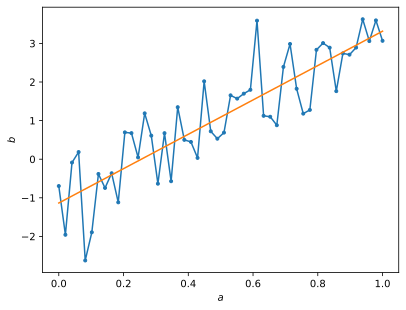

In [10]:
# print displays strings containing data.
print(f"Efficiency comparison\n")
print(f"pinv     :  accuracy {accur_pinv:5.2e}, time {t_pinv:5.2e}s")
print(f"solve    :  accuracy {accur_nrml:5.2e}, time {t_nrml:5.2e}s")
print(f"qr       :  accuracy {accur_qr:5.2e}, time {t_qr:5.2e}s")
print(f"lstsq    :  accuracy {accur_ls:5.2e}, time {t_ls:5.2e}s")

# solve command is (usually) faster but Pinv more accurate ==> we take the data from the first method
x1, x2 = x_pinv

# to plot the line we need only two points
b0 = x1 * 0 + x2
b1 = x1 * 1 + x2
plt.plot(a, b, '.-')
plt.plot([0, 1], [b0, b1])
plt.xlabel('$a$')
plt.ylabel('$b$')
plt.show()

**Task 1d**: Introduce 3 outliers in your measurements *b* with standard deviation of *20*. Check what happens with the fitted line in your plot.

For the sake of complete randomness, instead of _choosing_ three indices to perturb, it is nice to _sample_ them uniformly. For this purpose we may use `np.random.choice(N, size=k, replace=False)` which returns a row `k` vector of indices _sampled uniformly at random_, without replacement, from the integers 1 to N.

20 times a Gaussian variable with standard deviation 1 is a Gaussian variable with standard deviation 20.

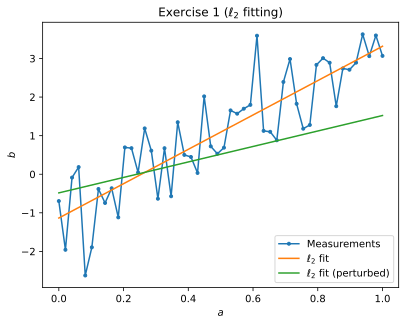

In [11]:
b_perturbed = np.copy(b)  # copy the original measurements (don't want to overwrite them)
indices = rng.choice(N, size=3, replace=False)  # sample 3 distinct indices in 1...N

# Assign pertubed values to the corresponding positions
b_perturbed[indices] += 20 * rng.standard_normal((3, 1))

# repeat the previous computations for the perturbed solution
z_perturbed = np.linalg.lstsq(A, b_perturbed, rcond=None)[0]
x1_perturbed, x2_perturbed = z_perturbed

# to plot the line b=x₁a+x₂ need only two points
b0_perturbed = x1_perturbed * 0 + x2_perturbed
b1_perturbed = x1_perturbed * 1 + x2_perturbed
plt.plot(a, b, '.-', label='Measurements')
plt.plot([0, 1], [b0, b1], '-', label='$\ell_2$ fit')
plt.plot([0, 1], [b0_perturbed, b1_perturbed], '-', label='$\ell_2$ fit (perturbed)')
plt.legend(loc='lower right')
plt.title(r'Exercise 1 ($\ell_2$ fitting)')
plt.xlabel('$a$')
plt.ylabel('$b$')
plt.show()

**Task 1e**: Plot the outliers to see how much they perturb.

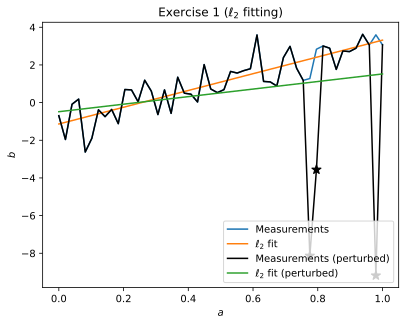

In [12]:
plt.plot(a[indices], b_perturbed[indices], 'k*', markersize=10)
plt.plot(a,b,label='Measurements')
plt.plot([0, 1], [b0, b1], '-', label='$\ell_2$ fit')
plt.plot(a, b_perturbed, 'k-',label='Measurements (perturbed)')
plt.plot([0, 1], [b0_perturbed, b1_perturbed], '-', label='$\ell_2$ fit (perturbed)')
plt.legend(loc='lower right')
plt.title(r'Exercise 1 ($\ell_2$ fitting)')
plt.xlabel('$a$')
plt.ylabel('$b$')
plt.show()

### Exercise 2: Linear $\ell_{\infty}$ fitting

Non-differentiable function:

$$
\min_{x \in \mathbb{R}^2}{ \max_{i=1, \dots, N}\{ \lvert x_1 a_i + x_2 - b_i \rvert \} } =
\min_{x \in \mathbb{R}^2}{ \lVert Ax - b \rVert_\infty }
$$

Introduce a slack variable $s$ to form an equivalent problem:

$$
\min_{x \in \mathbb{R}^2, s \in \mathbb{R}}{s} \text{ subject to } -s \leq a_i x_1 + x_2 - b_i \leq s, \, i = 1, \dots, N
$$

**Task 2a**: Which type of optimization problem is this?

 Both the objective function $f(x_1, x_2 ,s)=s$ and the constraints
 $-s\leq x_1 a_i+x_2-b_i\leq s$ for $i=1\ldots N$ are *linear*, therefore we are
 talking about *linear programming*.
 

**Task 2b**: Query the `linprog` documentation.

To get the nicely formatted version of the documentation, with cross-references and nicely rendered math, it is recommended to use the official online documentation, e.g. <https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html>.

In [13]:
# ?linprog
help(linprog)

Help on function linprog in module scipy.optimize._linprog:

linprog(c, A_ub=None, b_ub=None, A_eq=None, b_eq=None, bounds=(0, None), method='highs', callback=None, options=None, x0=None, integrality=None)
    Linear programming: minimize a linear objective function subject to linear
    equality and inequality constraints.
    
    Linear programming solves problems of the following form:
    
    .. math::
    
        \min_x \ & c^T x \\
        \mbox{such that} \ & A_{ub} x \leq b_{ub},\\
        & A_{eq} x = b_{eq},\\
        & l \leq x \leq u ,
    
    where :math:`x` is a vector of decision variables; :math:`c`,
    :math:`b_{ub}`, :math:`b_{eq}`, :math:`l`, and :math:`u` are vectors; and
    :math:`A_{ub}` and :math:`A_{eq}` are matrices.
    
    Alternatively, that's:
    
    - minimize ::
    
        c @ x
    
    - such that ::
    
        A_ub @ x <= b_ub
        A_eq @ x == b_eq
        lb <= x <= ub
    
    Note that by default ``lb = 0`` and ``ub = None``. Other b

**Task 2c** Formulate the problem in `linprog`'s form of linear programming.

$$
\begin{aligned}
    \operatorname*{minimize\ }_{\tilde x} \quad & c^\top \tilde x \\
    \mathrm{subject\ to} \quad & A_\mathrm{ub} \tilde x \le b_\mathrm{ub} \\
    \quad & A_\mathrm{eq} \tilde x = b_\mathrm{eq} \\
    \quad & l \le \tilde x \le u.
\end{aligned}
$$

Define the matrix $A_\mathrm{ub}$ and the vectors $c$, $b_\mathrm{ub}$ with your variables ordered
$\tilde x = (x_1, x_2, s)$. Use the matrix $A$ from the previous exercise to define $A_\mathrm{ub}$.
- *Optimization variable $\tilde x$.* We have three optimization variables,
namely $x_1$, $x_2$ and $s$. Our optimization *vector* is therefore
$\tilde x=(x_1, x_2 ,s)$ (as usual, we represent it as a *column* vector).
- *Objective function $c^\top \tilde x$.* The objective function is
simply $s$. Therefore, we have to take $c=(0,0,1)$.
- *Box $l \leq \tilde x \leq u$ or equality constraints $A_\mathrm{eq} \tilde x = b_\mathrm{eq}$* are absent.
- *Inequality constraints $A_\mathrm{ub} \tilde x\leq b_\mathrm{ub}$.* Since this formulation has only $\leq$ inequalities,
we have to change the sign of all the inequalities involving $\geq$. The
inequalities therefore become 

$$
    \left\{
    \begin{aligned}
    a_i x_1+x_2-b_i &{}\leq s & \rightarrow &&
    a_i x_1+x_2-s   &{}\leq b_i &&\text{these remain unchanged}
    \\
    a_i x_1+x_2-b_i &{}\geq -s & \rightarrow &&
    -a_i x_1-x_2-s &{}\leq -b_i &&\text{in these we changed sign}
    \\
    &&&&&&&\text{for all } i=1\ldots N
    \end{aligned}
    \right.
$$

If we stack them all together one over the other we easily obtain the matrix
compact form $A_\mathrm{ub} \tilde x\leq b_\mathrm{ub}$

$$
    \underbrace{
    \begin{bmatrix}
    a_1 & 1 & -1 \\
    \vdots~ & \vdots~ & \vdots~ \\
    a_N & 1 & -1 \\
    -a_1 & -1 & -1 \\
    \vdots~ & \vdots~ & \vdots~ \\
    -a_N & -1 & -1
    \end{bmatrix}
    }_{A_\mathrm{ub}}
    \underbrace{
    \begin{bmatrix}
    x_1 \\
    \\
    x_2 \\
    \\
    s \\
    \end{bmatrix}
    }_{\tilde x}
    {}\leq{}
    \underbrace{
    \begin{bmatrix}
    b_1 \\
    \vdots \\
    b_N \\
    -b_1 \\
    \vdots \\
    -b_N \\
    \end{bmatrix}
    }_{b_\mathrm{ub}}.
$$
 
Therefore, using $A$ and $b$ from the previous exercise (see (1.1)),

$$
    A_\mathrm{ub}
    {}={}
    \begin{bmatrix}
    A & -{\bf 1}\\
    -A & -{\bf 1}
    \end{bmatrix}
    ~~~~\text{and}~~~~
    b_\mathrm{ub}
    {}={}
    \begin{bmatrix}
    b\\
    -b
    \end{bmatrix}
    ~~~~\text{where}~~~~
    {\bf 1}
    {}={}
    \begin{bmatrix}
    1\\
    \vdots\\
    1
    \end{bmatrix}.
$$


**Task 2d**: Solve the problem using the measurements *b* from the previous exercise
 both with and without outliers and compare the results. (Disclaimer: the fit
 with outliers will be pretty bad.)
 
 - To stack arrays in sequence vertically (row wise), you can use `np.vstack()` command. To stack arrays in sequence horizentally (column-wise), you can use `np.hstack()` command.

In [14]:
# The coefficients of the linear objective function to be minimized
c = np.vstack([0, 0, 1])

# The inequality constraint matrix
A_ub = np.vstack((np.hstack((A, -ones_vector)), np.hstack((-A, -ones_vector))))

# The inequality constraint right-hand side vector
b_ub = np.vstack((b, -b))

# Solve the LP
result = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=(None, None))

# Extract the variables from the solution
x1_inf, x2_inf, s_inf = result.x

In [15]:
# Repeat everything for the perturbed mesurements b_perturbed, now appending '_inf_perturbed'
b_ub_perturbed = np.vstack((b_perturbed, -b_perturbed))
result_perturbed = linprog(c=c, A_ub=A_ub, b_ub=b_ub_perturbed, bounds=(None, None))

x1_inf_perturbed, x2_inf_perturbed, s_inf_perturbed = result_perturbed.x

The quantity $s$ is to be minimized, i.e., the $\ell_{\infty}$ norm in the objective function. Therefore comparing the two minimization problems amounts to comparing `s_inf` and `s_inf_perturbed`.

In [16]:
print(f"cost without outliers: {s_inf:8.4f}")
print(f"cost with outliers:    {s_inf_perturbed:8.4f}")

cost without outliers:   1.6156
cost with outliers:      6.2984


In [17]:
# As before, we need two points to draw the fitting line(s) b = x1 a + x2.
b0_inf = x1_inf * 0 + x2_inf
b1_inf = x1_inf * 1 + x2_inf
b0_inf_perturbed = x1_inf_perturbed * 0 + x2_inf_perturbed
b1_inf_perturbed = x1_inf_perturbed * 1 + x2_inf_perturbed

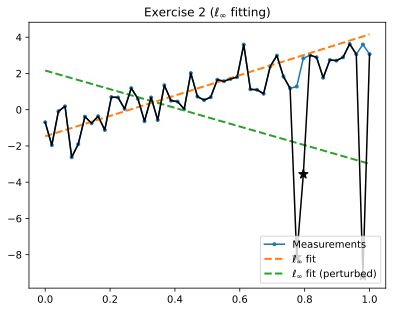

In [18]:
plt.figure()
plt.plot(a, b, '.-', label='Measurements')

# For the new data we use dashed lines with '--' option and double the linewidth
plt.plot([0, 1], [b0_inf, b1_inf],'--', linewidth=2, label='$\ell_{\infty}$ fit')
plt.plot([0, 1], [b0_inf_perturbed, b1_inf_perturbed],'--', linewidth=2, label='$\ell_{\infty}$ fit (perturbed)')

# Task 2e We may also plot the outliers to see how much they perturb
plt.plot(a, b_perturbed, 'k')
plt.plot(a[indices], b_perturbed[indices], 'k*', markersize=10)

plt.legend(loc='lower right')
plt.title(r'Exercise 2 ($\ell_\infty$ fitting)')
plt.show()

### Exercise 3: Linear $\ell_1$ fitting

Non-differentiable function:

$$
\min_{x \in \mathbb{R}^2}{ \sum_{i=1}^n{ \lvert x_1 a_i + x_2 - b_i \rvert } } =
\min_{x \in \mathbb{R}^2}{ \lVert Ax - b \rVert_1 }
$$

Introduce a slack variable $s$ to form an equivalent problem:

$$
\min_{x \in \mathbb{R}^2, s \in \mathbb{R}^N}{ \sum_{i=1}^N{s_i} } \text{ subject to } -s \leq a_i x_1 + x_2 - b_i \leq s, \, i = 1, \dots, N
$$
 
**Task 3a**: Which type of optimization problem is this?
The solver in Python to solve these problems is called `linprog`.

Both the objective function $f(x_1,x_2,s)=\sum_{i=1}^Ns_i$ and the constraints
$-s_i\leq x_1 a_i+x_2-b_i\leq s_i$ for $i=1\ldots N$ are *linear*, therefore we are
again dealing with a *linear program*.

**Task 3b** Formulate the problem in *linprog*'s form of linear programming.

$$
\begin{aligned}
    \operatorname*{minimize\ }_{\tilde x} \quad & c^\top \tilde x \\
    \mathrm{subject\ to} \quad & A_\mathrm{ub} \tilde x \le b_\mathrm{ub} \\
    \quad & A_\mathrm{eq} \tilde x = b_\mathrm{eq} \\
    \quad & l \le \tilde x \le u.
\end{aligned}
$$

Define the matrix $\overline{A}$ and the vectors $c$, $b_\mathrm{ub}$ if your variables are ordered
$\tilde x = (x_1, x_2, s)$. Use the matrix $A$ from the previous exercise to define $A_\mathrm{ub}$.

 - *Optimization variable $\tilde x$.* We have $N+2$ optimization variables,
 namely $x_1$, $x_2$ and the vector $s$. Our optimization *vector* is therefore
 $\tilde x=(x_1,x_2,s)$ (as usual, we shall represent it as *column* vector).
 - *Objective function $c^\top \tilde x$.* The objective function is
 $\sum_{i=1}^Ns_i$. Therefore, we have to take $c=(0,0,1,1,\cdots,1)$
 so that $c^\top \tilde x=0x_1+0x_2+1s_1+1s_2+\ldots 1s_N=\sum_{i=1}^Ns_i$.
 - *Box $l \leq \tilde x \leq u$ or equality constraints $A_\mathrm{eq}\tilde x = b_\mathrm{eq}$* are absent.
 - *Inequality constraints $A_\mathrm{ub}\tilde x\leq b_\mathrm{ub}$.* Since we have only $\leq$ inequalities,
we have to change the sign of all the inequalities involving $\geq$. The
inequalities in (1.3b) therefore become

$$
    \left\{
    \begin{aligned}
    a_i x_1+x_2-b_i &{}\leq s_i & \rightarrow &&
    a_i x_1+x_2-s_i &{}\leq b_i &&\text{these remain unchanged}
    \\
    a_i x_1+x_2-b_i  &{}\geq -s_i & \rightarrow &&
    -a_i x_1-x_2-s_i &{}\leq -b_i &&\text{in these we changed sign}
    \\
    &&&&&&&\text{for all } i=1\ldots N
    \end{aligned}
    \right.
$$

If we stack them all together one over the other we easily obtain the matrix
compact form $A_\mathrm{ub}\tilde x\leq b_\mathrm{ub}$

$$
    \underbrace{
    \begin{bmatrix*}[r]
    a_1     & 1       & -1 \\
    \vdots~ & \vdots~ &    & \ddots~ \\
    a_N     & 1       &    &        & -1 \\
    -a_1    & -1      & -1 \\
    \vdots~ & \vdots~ &    & \ddots~ \\
    -a_N    & -1      &    &        & -1
    \end{bmatrix*}
    }_{A_\mathrm{ub}}
    \underbrace{
    \begin{bmatrix*}[r]
    x_1 \\
    x_2 \\
    s_1 \\
    s_2 \\
    \vdots~\\
    s_N
    \end{bmatrix*}
    }_{\tilde x}
    {}\leq{}
    \underbrace{
    \begin{bmatrix*}[r]
    b_1 \\
    \vdots \\
    b_N \\
    -b_1 \\
    \vdots \\
    -b_N \\
    \end{bmatrix*}
    }_{b_\mathrm{ub}}
$$
 
therefore, using $A$ and $b$ from the previous exercise (see (1.1)),

$$
    A_\mathrm{ub}
    {}={}
    \begin{bmatrix*}[r]
    A & -\mathrm I\\
    -A & -\mathrm I
    \end{bmatrix*}
    ~~~~\text{and}~~~~
    b_\mathrm{ub}
    {}={}
    \begin{bmatrix*}[r]
    b\\
    -b
    \end{bmatrix*}
$$

where $\mathrm I\in \mathrm{I\!R}^{N\times N}$ is the identity matrix.



**Task 3c**: Solve the problem using the measurements *b* from the previous exercise (both with and without outliers) and compare the results.

In [19]:
# recall: np.hstack() to stack horizontally, np.vstack() to stack vertically
c = np.vstack([0,0,ones_vector])
A_ub = np.vstack ((np.hstack((A,-np.identity(N))), np.hstack((-A,-np.identity(N)))))
b_ub = np.vstack((b, -b))
result = linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=(None, None))  # minimize cᵀx̃   s.t.  A_ub x̃ ≤ b_ub

# to distinguish from the previous exercise, we append '_1' as in $\ell_\infty$ fitting
(x1_1, x2_1), s_1 = np.split(result.x, [2])

# We repeat everything for the perturbed mesurements b_perturbed, now appending '_1_perturbed'
b_ub_perturbed =np.vstack((b_perturbed, -b_perturbed))
result_perturbed = linprog(c=c, A_ub=A_ub, b_ub=b_ub_perturbed, bounds=(None, None))

(x1_1_perturbed, x2_1_perturbed), s_1_perturbed = np.split(result_perturbed.x, [2])

 `sum(s)` is the quantity to be minimized, i.e., the $\ell_1$ norm in the objective function in (1.2). Therefore comparing the two minimization problems amounts to comparing `sum(s_1)` and `sum(s_1_p)`.

In [20]:
print(f"cost without outliers: {sum(s_1):8.4f}")
print(f"cost with outliers:    {sum(s_1_perturbed):8.4f}")

# alternatively, you could use
print(f"cost without outliers: {result.fun:8.4f}")
print(f"cost with outliers:    {result_perturbed.fun:8.4f}")

cost without outliers:  30.1373
cost with outliers:     56.8067
cost without outliers:  30.1373
cost with outliers:     56.8067


 As done before, we may also plot the outcome. As before, we need two points to draw the fitting line(s) $b = x_1 a + x_2$.

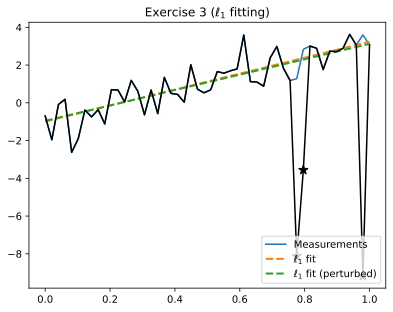

In [21]:
b0_1 = x1_1 * 0 + x2_1
b1_1 = x1_1 * 1 + x2_1
b0_1_perturbed = x1_1_perturbed * 0 + x2_1_perturbed
b1_1_perturbed = x1_1_perturbed * 1 + x2_1_perturbed

plt.figure()
plt.plot(a, b, label="Measurements")

# For the new data we use dashed lines with '--' option and double the linewidth
plt.plot([0, 1], [b0_1, b1_1], "--", linewidth=2, label="$\ell_{1}$ fit")
plt.plot([0, 1], [b0_1_perturbed, b1_1_perturbed], "--", linewidth=2, label="$\ell_{1}$ fit (perturbed)")

# We may also remark outliers
plt.plot(a, b_perturbed, "k")
plt.plot(a[indices], b_perturbed[indices], "k*", markersize=10)

plt.legend(loc="lower right")
plt.title(r"Exercise 3 ($\ell_1$ fitting)")
plt.show()

## *Conclusions*

 - $\ell_2$ fitting minimizes the *mean square* error; it finds the line for
 which the error is most homogeneous (in some sense it minimizes the variance).
 - $\ell_\infty$ fitting minimizes the *largest* error, i.e., the worst that can
 happen and is therefore *extremely sensitive to outliers*.
 - $\ell_1$ fitting minimizes the *average* error, and is therefore *less
 sensitive to outliers*.

We may plot the absolute error to verify these claim. To nest different plots
on the same figures we can use `plt.subplot(m, n, i)` which places the following
plots in the *i*-th position of an *m* by *n* grid. We here consider a *2* by
*1* grid. (For compatibility with Matlab, index 1 (and not 0) refers to the
first subplot.)



 

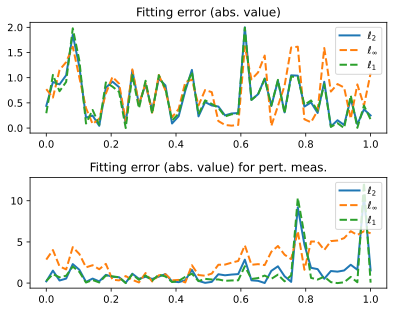

In [22]:
plt.figure()
plt.subplot(2,1,1)
plt.title('Fitting error (abs. value)')
plt.plot(a,abs(b-(x1*a+x2)), linewidth=2, label='$\ell_2$')
plt.plot(a,abs(b-(x1_inf*a+x2_inf)),'--', linewidth=2, label='$\ell_{\infty}$')
plt.plot(a,abs(b-(x1_1*a+x2_1)),'--', linewidth=2, label='$\ell_1$')
plt.legend(loc='upper right')

plt.subplots_adjust(hspace=.4) 

plt.subplot(2,1,2)
plt.title('Fitting error (abs. value) for pert. meas.')
plt.plot(a,abs(b_perturbed-(x1_perturbed*a+x2_perturbed)), linewidth=2, label='$\ell_2$')
plt.plot(a,abs(b_perturbed-(x1_inf_perturbed*a+x2_inf_perturbed)),'--', linewidth=2, label='$\ell_{\infty}$')
plt.plot(a,abs(b_perturbed-(x1_1_perturbed*a+x2_1_perturbed)),'--', linewidth=2, label='$\ell_1$')
plt.legend(loc='upper right')

plt.show()

 As you can see, on average the $\ell_2$ and $\ell_1$ fittings produce a smaller
 error, however their maximum error is larger than that of the $\ell_\infty$
fitting. This is more evident when the measurements are noisier, as the
 $\ell_\infty$ fitting is much more sensitive to perturbations.